# Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

In [3]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.95
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/processed/predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_self_training_sample.csv"
ALERT_FROM_CLASS = "Unhealthy"

,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.756909,0.727654,324523,52052,0.9
1,2,0.748707,0.719371,272471,133751,0.9
2,3,0.719874,0.686680,138720,47589,0.9
3,4,0.713880,0.677127,91131,17407,0.9
4,5,0.660631,0.602469,73724,6065,0.9
5,6,0.692934,0.648904,67659,4897,0.9
6,7,0.699558,0.658210,62762,4563,0.9
7,8,0.666246,0.609910,58199,1901,0.9
8,9,0.671798,0.617312,56298,1331,0.9
9,10,0.729338,0.696955,54967,6137,0.9


Test accuracy: 0.5421990282526543
Test f1_macro: 0.4360301017733679


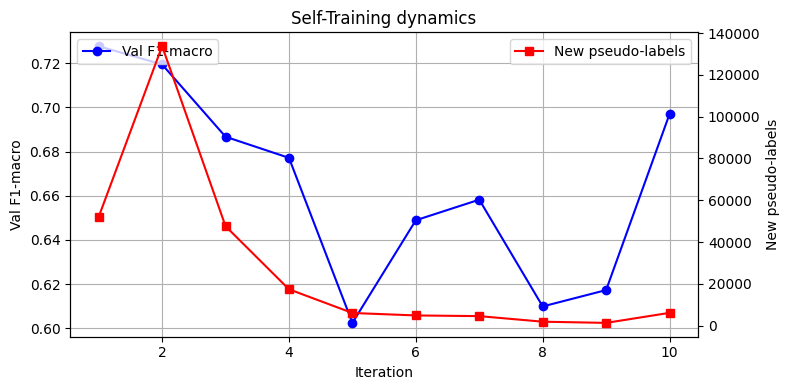

Saved metrics to: D:\air_guard_miniproject\data\runs\metrics_self_training.json


In [4]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- ĐOẠN FIX LỖI ĐƯỜNG DẪN (PATH) ---
PROJECT_ROOT = Path(".").resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
# -------------------------------------

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

# 1. Định nghĩa lại các tham số (Đảm bảo đường dẫn dataset đúng với Bước 2)
SEMI_DATASET_PATH = "data/processed/semi_labeled_data.parquet"
CUTOFF = "2017-01-01"
TAU = 0.90 # Ngưỡng tự tin (confidence threshold) [cite: 105]
MAX_ITER = 10 # Số vòng lặp tối đa [cite: 109]
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42
ALERT_FROM_CLASS = "Unhealthy"

# Đường dẫn lưu kết quả
METRICS_PATH = "data/runs/metrics_self_training.json"
PRED_SAMPLE_PATH = "data/runs/predictions_self_training_sample.csv"
ALERTS_SAMPLE_PATH = "data/runs/alerts_self_training_sample.csv"

# 2. Đọc dữ liệu
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

# 3. Cấu hình và chạy thuật toán
data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
st_cfg = SelfTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

# Chạy quy trình self-training: lặp lại việc gán nhãn giả và huấn luyện lại [cite: 11, 14]
out = run_self_training(df, data_cfg, st_cfg)
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

# 4. Hiển thị kết quả và biểu đồ
display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# Trực quan hóa diễn biến qua các vòng lặp [cite: 114, 181]
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color='b', label='Val F1-macro')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro")
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(history["iter"], history["new_pseudo"], marker="s", color='r', label='New pseudo-labels')
ax2.set_ylabel("New pseudo-labels")
ax2.legend(loc='upper right')
plt.title("Self-Training dynamics")
plt.tight_layout()
plt.show()

# 5. Lưu các tệp kết quả (Artifacts) [cite: 117]
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
metrics_path.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "self_training",
    "data_cfg": data_cfg.__dict__,
    "st_cfg": st_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
}
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print("Saved metrics to:", metrics_path)